## Analysis_300
This notebook deals with the analysis of my third research question 'What python packages are similar by description?'

## Purpose
* This notebook analyses the description data from pypi, scraped in Prep_300
* Descriptions are tokenised and the tokens are cleaned
* Tf-idf vectorisation is used to look at importance of words in each description 

These are libraries that had to be installed for this analysis

In [1]:
# %%cmd
# python -m pip install wordcloud

In [2]:
# import nltk
# nltk.download('stopwords')

In [3]:
# nltk.download('wordnet')

In [4]:
# nltk.download('averaged_perceptron_tagger')

In [5]:
#Import relevant libraries
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import string
import time 
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn import metrics
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
pypi_description = pd.read_csv('../data/CSV_files/pypi_descrip.csv') 
pypi_description.head()

,Description,Name,Summary
0,It provides:\r\n\r\n- a powerful N-dimensional...,numpy,NumPy is the fundamental package for array com...
1,"**pandas** is a Python package providing fast,...",pandas,"Powerful data structures for data analysis, ti..."
2,Use `scikit-learn <https://pypi.python.org/pyp...,sklearn,A set of python modules for machine learning a...
3,Matplotlib strives to produce publication qual...,matplotlib,Python plotting package
4,Seaborn is a library for making statistical gr...,seaborn,seaborn: statistical data visualization


### Check for Missing Data

In [7]:
if((len(pypi_description[pypi_description['Summary'].isnull()])) > 0):
    print("Content Missing:")
    print(pypi_description[pypi_description['Summary'].isnull()])
else:
    print("All content present")

Content Missing:
                                            Description            Name  \
36                                                  NaN              io   
37    keras\_datasets\r\n===============\r\n\r\nA re...  keras-datasets   
45                                                  NaN        unittest   
90                                                  NaN            root   
136                                                 NaN             ABC   
185                                                 NaN        commands   
224                              # plotting\r\n\r\n\r\n        plotting   
384                                                 NaN             upm   
425   src\r\n===\r\n\r\nNot your source.\r\n\r\nBeca...             src   
431                                                 NaN       bootstrap   
439                                                 NaN         trainer   
442                                                 NaN         chaospy   
462     

In [8]:
pypi_description = pypi_description.dropna()

### Removing URLs from description
Some descriptions had links to images etc. I removed these as they were interfering with similarity results.

In [9]:
pypi_description['Description'] = pypi_description['Description'].str.replace(r'http\S+', '', case=False)

In [10]:
pypi_description = pypi_description.drop(pypi_description.columns[2], axis=1)

Dropping summary column

In [11]:
pypi_description.head()

,Description,Name
0,It provides:\r\n\r\n- a powerful N-dimensional...,numpy
1,"**pandas** is a Python package providing fast,...",pandas
2,Use `scikit-learn < instead.,sklearn
3,Matplotlib strives to produce publication qual...,matplotlib
4,Seaborn is a library for making statistical gr...,seaborn


## Tokenization
Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens. In the process of tokenization, some characters like punctuation marks are discarded.

#### Make a list containing all the token lists for each description.

In [12]:
wordExp = r'\w+' # this pattern finds all the words
tokenizer = RegexpTokenizer(wordExp)

tokensList = [] # this is a list of lists. Each list contains the tokens of a document.

for description in pypi_description['Description']:
    token_words = tokenizer.tokenize(description) #tokenize all words in the document
    tokensList.append(token_words) #add this list to tokensList

We now have a lists of lists, where each list contains the tokens for each article in order. Below shows what the list looks like.

In [14]:
print(tokensList[1][:10])

['pandas', 'is', 'a', 'Python', 'package', 'providing', 'fast', 'flexible', 'and', 'expressive']


### Decapitalization
* This function decapitalizes all words in token list.
* This step will only decapitalise words with capital letter at the beginning of the word.
* We do not depactialize words that are all capitals due to the importance of acronyms. For example, "US" (the country) should not be changed to "us" (group of people).

In [15]:
def decapitalise(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        
        decapitalised = [] #this will store a list of decapitalised tokens from a single doc
        for word in tokens: #for each word in the list
            if not word.isupper(): #don't decapitalise if the whole word is in uppercase anyway - avoids decapitalising acronyms like US, LA, ID 
                decapitalised.append(word.lower()) # change to lower case
            else:
                decapitalised.append(word)
        newTokenList.append(decapitalised) #add decapitalised list to overall list
        
    return newTokenList

### Stopwords
* This step removes stopwords from the token list to remove noise like "the", "a", etc.
* We got the stopwords list from the default nltk list

In [16]:
def remove_stopwords(list_of_tokenLists):
    stopword_list = stopwords.words('english') #impotr default nltk stopwords
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        notStop = [] #this will store a list of non-stopword tokens from a single doc
        for word in tokens: #for each word in the list
            if word not in stopword_list: #if word is not a stopword, append it
                notStop.append(word)
        newTokenList.append(notStop) #append newlist to the overall list
        
    return newTokenList

### Remove Numbers
* This removes numbers from the token list  
* Does not remove words that contain numbers eg. 2nd, 3g etc. Sometimes there'll be unusual tokens, for example, 0.04s ("0.04 seconds") may be changed to 004s and lose its meaning. However, we are confident that these few outliers won't negatively affect our overall accuracy.

In [17]:
def remove_numbers(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        
        noNumbers= [] #this will store a list of tokens from a single doc
        for word in tokens: #for each word in the list#
            if not word.isdigit():
                noNumbers.append(word) # remove number
        newTokenList.append(noNumbers)
        
    return newTokenList

###  Expand Contractions
* Contractions are shortened version of words or syllables. 
* Converting each contraction to its expanded, original form helps with text standardization.

In [18]:
#expandContractions
def expandContractions(inputList):
    contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": " what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    }
    #for every word in the input text
    for list_of_tokens in inputList:
        for word in list_of_tokens:
            # if the word is in our dictionary replace it with the expanded version.
            if (word.lower() in contractions):
                inputList = inputList.replace(word, contractions[word.lower()])
            #if the word contains a hyphen, we'll replace the hyphen with a space leaving two words
            if ("-" in word):
                inputList = inputList.replace(word, word.replace("-", " "))
    return (inputList)

### Punctuation
* This step removes puntuation from the list, eg.  " . , - ; "
* Removing punctuation should not be done before removing contractions as this will interfere with the process - contractions with hyphens and apostrophes won't be found.

In [19]:
def punctuation(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    
    for tokens in list_of_tokenLists: #for each list in the big list
        
        depunctuated = [] #this will store a list of tokens from a single doc
        for word in tokens: #for each word in the list
            depunctuated.append(word.translate(string.punctuation)) # remove punctuation
        newTokenList.append(depunctuated)
    return newTokenList

### Lemmatization

This ensures all variants of words will be counted the same, e.g "cats" and "cat" will be counted together.

In [20]:
def lemmatize(list_of_tokenLists):
    newTokenList = [] #this will store the new list
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for tokens in list_of_tokenLists:
        tempLemmatized = []
        for word in tokens:
            tempLemmatized.append(wordnet_lemmatizer.lemmatize(word))
        newTokenList.append(tempLemmatized)
    return newTokenList

### Cleaning Tokens

This step will perform the cleaning function and show the difference between our old tokens and new tokens.

In [21]:
def clean(list_of_tokenLists):
    list_of_tokenLists = expandContractions(list_of_tokenLists) #expand contractions
    list_of_tokenLists = decapitalise(list_of_tokenLists) #decapitalise
    list_of_tokenLists = remove_stopwords(list_of_tokenLists) #remove stopwords
    list_of_tokenLists = punctuation(list_of_tokenLists) #remove punctuation
    list_of_tokenLists = remove_numbers(list_of_tokenLists) #remove numbers
    list_of_tokenLists = lemmatize(list_of_tokenLists)
    return list_of_tokenLists


print("Tokens Before: ")
print(tokensList[1][:10])
print("------------")

tokensList = clean(tokensList) # clean


print("Tokens After: ")
print(tokensList[1][:10])

Tokens Before: 
['pandas', 'is', 'a', 'Python', 'package', 'providing', 'fast', 'flexible', 'and', 'expressive']
------------
Tokens After: 
['panda', 'python', 'package', 'providing', 'fast', 'flexible', 'expressive', 'data', 'structure', 'designed']


We see the cleaning function was successful, as both lists are different.

####  Add tokens column to the dataframe

In [22]:
pypi_description['tokens'] = tokensList
pypi_description.head()

,Description,Name,tokens
0,It provides:\r\n\r\n- a powerful N-dimensional...,numpy,"[provides, powerful, N, dimensional, array, ob..."
1,"**pandas** is a Python package providing fast,...",pandas,"[panda, python, package, providing, fast, flex..."
2,Use `scikit-learn < instead.,sklearn,"[use, scikit, learn, instead]"
3,Matplotlib strives to produce publication qual...,matplotlib,"[matplotlib, strives, produce, publication, qu..."
4,Seaborn is a library for making statistical gr...,seaborn,"[seaborn, library, making, statistical, graphi..."


####  Add joined tokens column to dataframe

In [23]:
tokenContentList = []

for i in tokensList:
    tokenContentList.append(" ".join(i))

pypi_description['train_clean_content'] = tokenContentList
pypi_description.head()

,Description,Name,tokens,train_clean_content
0,It provides:\r\n\r\n- a powerful N-dimensional...,numpy,"[provides, powerful, N, dimensional, array, ob...",provides powerful N dimensional array object s...
1,"**pandas** is a Python package providing fast,...",pandas,"[panda, python, package, providing, fast, flex...",panda python package providing fast flexible e...
2,Use `scikit-learn < instead.,sklearn,"[use, scikit, learn, instead]",use scikit learn instead
3,Matplotlib strives to produce publication qual...,matplotlib,"[matplotlib, strives, produce, publication, qu...",matplotlib strives produce publication quality...
4,Seaborn is a library for making statistical gr...,seaborn,"[seaborn, library, making, statistical, graphi...",seaborn library making statistical graphic pyt...


## Analysis of Corpus

Here, we will analyse our newly cleaned description content.

### Wordcloud of whole corpus

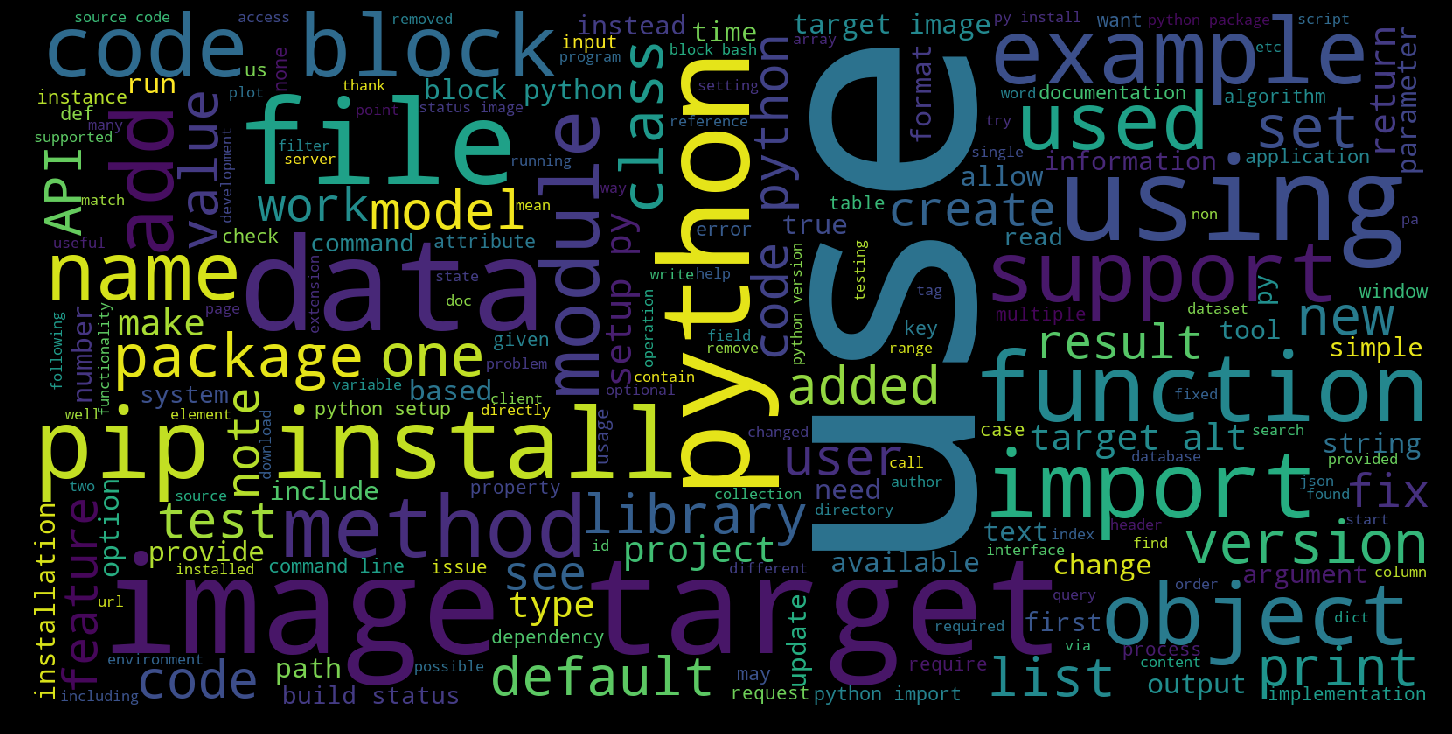

In [24]:
masterWordList = []

for content in pypi_description['train_clean_content']:
        masterWordList.append(content) #add each content to list

text = ' '.join(masterWordList) #join all of the corpus words

def wordcloud(words):
    wordcloud = WordCloud(width=1600, height=800).generate(text)
    plt.figure(figsize=(20,10), facecolor='k') #adjust size and color
    plt.imshow(wordcloud) #show wordcloud on plot
    plt.tight_layout(pad=0) #tight layout
    plt.axis("off") #dont show axis
    plt.show() #show visualisation
    
wordcloud(text)
#plt.savefig('img_wordcloud.png')

Here we have a wordcloud of all the words in the description corpus. Words such as pip and install are prominent as these are used for installing libraries. Other words such as python, import,  package, data etc are all related to importing libraries. 

## Most common bigrams and trigrams for corpus
Looking at the words that most commonly come together

In [25]:
text = ' '.join(masterWordList)
words = text.split()

#bigrams
n = 2
bigrams = list(ngrams(words, n))
bigram_frequency = nltk.FreqDist(bigrams)

print("5-top most common bigram:")
for i in list(bigram_frequency.most_common(5)):
    print(i)
    
print("\n-------------\n")
    
#trigrams
n = 3
trigrams = list(ngrams(words, n))
trigram_frequency = nltk.FreqDist(trigrams)

print("5-top most common trigram:")
for i in list(trigram_frequency.most_common(5)):
    print(i)

5-top most common bigram:
(('image', 'target'), 2996)
(('pip', 'install'), 2169)
(('code', 'block'), 1798)
(('code', 'python'), 1107)
(('target', 'alt'), 957)

-------------

5-top most common trigram:
(('image', 'target', 'alt'), 952)
(('code', 'block', 'python'), 926)
(('image', 'target', 'image'), 832)
(('target', 'image', 'target'), 825)
(('python', 'setup', 'py'), 647)


These are the words that appear most often together in the corpus. pip install is interesting as that is used for installing libraries.

### Count Vectorizer
Convert a collection of text documents to a matrix of token counts

In [26]:
documents = pypi_description['tokens'].apply(lambda x: (' ').join(x))
documents.head()

0    provides powerful N dimensional array object s...
1    panda python package providing fast flexible e...
2                             use scikit learn instead
3    matplotlib strives produce publication quality...
4    seaborn library making statistical graphic pyt...
Name: tokens, dtype: object

In [27]:
vec = CountVectorizer()
matrix = vec.fit_transform(documents)
matrix = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())

Getting tf_idf scores for use in Results_300

Tf-idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

## Cosine Similarity 

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.

In [30]:
# Getting the cosine similarity between each document
cosine_matrix =  cosine_similarity(matrix.values)
df_cosine = pd.DataFrame(cosine_matrix,index=range(4048),columns=range(4048))
df_cosine.head()

,0,1,2,3,4,5,6,7,8,9,...,4038,4039,4040,4041,4042,4043,4044,4045,4046,4047
0,1.000000,0.292490,0.000000,0.024001,0.130117,0.000000,0.224161,0.060718,0.073601,0.036538,...,0.122548,0.000000,0.000000,0.073601,0.077343,0.000000,0.008621,0.0,0.055427,0.063107
1,0.292490,1.000000,0.013236,0.045025,0.342152,0.054036,0.101236,0.079100,0.086689,0.083776,...,0.115348,0.000000,0.070592,0.086689,0.142895,0.000000,0.019767,0.0,0.034660,0.176922
2,0.000000,0.013236,1.000000,0.000000,0.000000,0.000000,0.049029,0.000000,0.010474,0.020550,...,0.052770,0.000000,0.000000,0.010474,0.013841,0.000000,0.033942,0.0,0.000000,0.086958
3,0.024001,0.045025,0.000000,1.000000,0.074469,0.077152,0.037062,0.045175,0.026391,0.046603,...,0.019945,0.094491,0.000000,0.026391,0.026157,0.000000,0.000000,0.0,0.082479,0.037562
4,0.130117,0.342152,0.000000,0.074469,1.000000,0.000000,0.054096,0.028259,0.023938,0.068021,...,0.111696,0.000000,0.026270,0.023938,0.089447,0.045502,0.032100,0.0,0.051594,0.121401


As there is not much similarity between these descriptions from cosine similarity I will make a threshold for 0.0 values a imports description can have.

In [31]:
dfc = df_cosine.replace(0.0, np.nan)

In [32]:
dfc1 = dfc.dropna(thresh=3720, axis = 1) 

In [33]:
columns = dfc1.columns.tolist()

In [34]:
new_dfc = dfc1[dfc1.index.isin(columns)]

In [35]:
new_dfc.head()

,14,32,68,79,95,96,101,162,189,199,...,3841,3872,3877,3880,3925,3964,4002,4018,4019,4038
14,1.000000,0.140273,0.160914,0.140094,0.215918,0.142905,0.102950,0.175790,0.211333,0.174803,...,0.144691,0.170555,0.142984,0.227418,0.161130,0.125194,0.224567,0.138260,0.156290,0.157128
32,0.140273,1.000000,0.131501,0.119914,0.194049,0.191612,0.157901,0.149409,0.131496,0.116054,...,0.078035,0.116525,0.076563,0.222598,0.161634,0.083411,0.197777,0.115713,0.115160,0.178646
68,0.160914,0.131501,1.000000,0.093611,0.475434,0.214677,0.116562,0.129408,0.204339,0.261977,...,0.101579,0.395159,0.109043,0.230516,0.262071,0.259343,0.237315,0.136559,0.135287,0.200123
79,0.140094,0.119914,0.093611,1.000000,0.156520,0.109821,0.056775,0.106496,0.123294,0.084495,...,0.134476,0.100410,0.055396,0.154075,0.104323,0.119382,0.133006,0.094467,0.069713,0.100964
95,0.215918,0.194049,0.475434,0.156520,1.000000,0.215079,0.125311,0.161466,0.322642,0.228103,...,0.142889,0.389920,0.139992,0.276591,0.324675,0.260110,0.257687,0.166833,0.144000,0.201977


### Saving to CSV file 

In [36]:
pypi_description.to_csv('../data/CSV_files/df_tokens.csv', index=False, encoding='utf-8')

In [37]:
new_dfc.to_csv('../data/CSV_files/cosine_sim.csv', index=False, encoding='utf-8')

Saving CSV file to be used in Results_300